-1
1.20000000000000
1.30000000000000
2
5.60000000000000
5
{0: (-8.0, 7), 2: (-6.0, 7), 4: (-4.0, 7), 9: (-2.0, 7), 12: (0.0, 7), 14: (2.0, 7), 16: (4.0, 7), 19: (6.0, 7), 22: (8.0, 7), 1: (-6.797765006978197, 6), 5: (-3.6435938626041557, 6), 6: (-1.5035490523794954, 6), 13: (1.3725901534765328, 6), 20: (3.584254347495763, 6), 24: (6.54133713318988, 6), 7: (-6.386637042314844, 5), 11: (-1.9339906193193497, 5), 18: (2.4602114023619577, 5), 25: (5.866634162947158, 5), 3: (-4.975530127668012, 4), 17: (0.006421774862102714, 4), 23: (4.977379917106727, 4), 8: (0.9078080450567214, 3), 10: (-1.192613873137638, 2), 15: (0.9925340386236396, 1), 21: (1.4165731903177137, 0)}


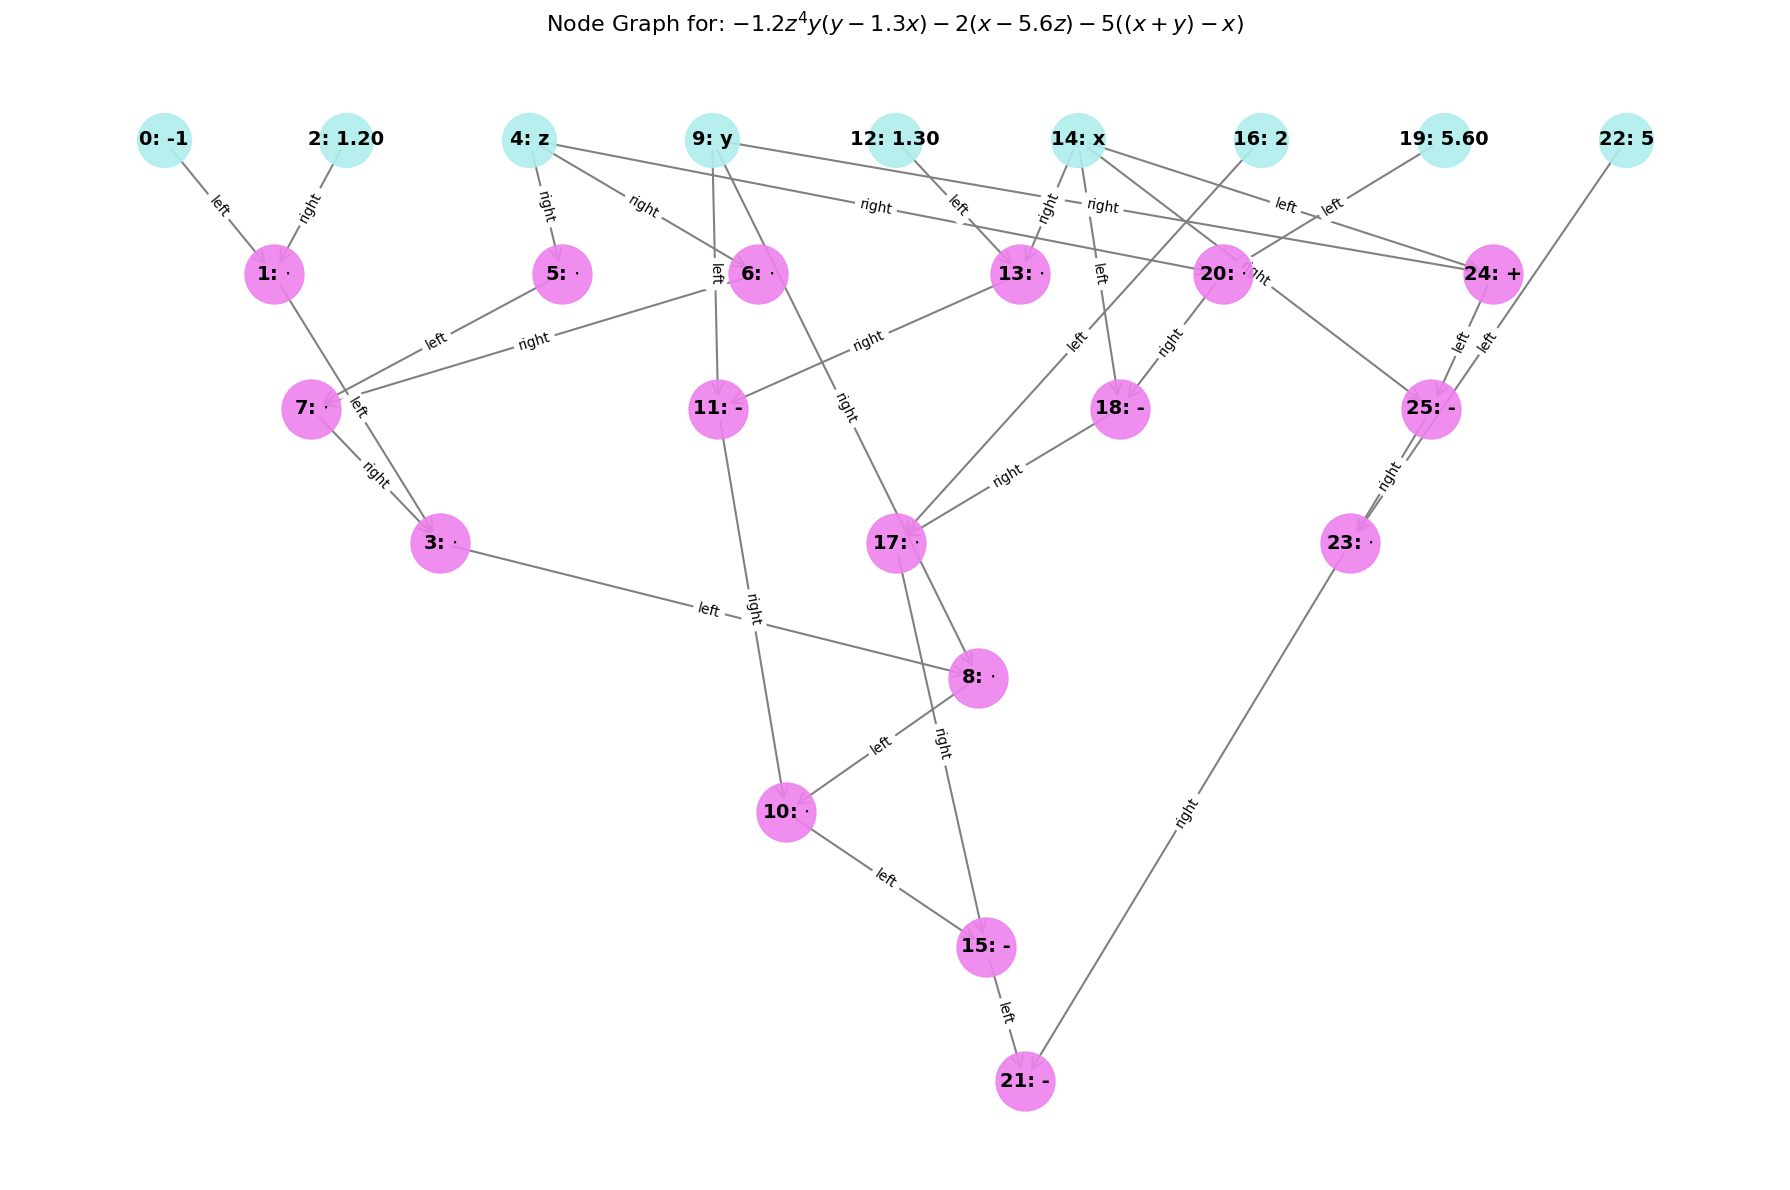

In [ ]:
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application
from collections import deque, defaultdict
import numpy as np
import random
import ast
from copy import deepcopy


class PolynomialParser(ast.NodeVisitor):
    def visit_BinOp(self, node):
        left = self.visit(node.left)
        right = self.visit(node.right)
        op = type(node.op)

        if op == ast.Add:
            return sp.Add(left, right, evaluate=False)
        elif op == ast.Sub:
            return sp.Add(left, sp.Mul(-1, right, evaluate=False), evaluate=False)
        elif op == ast.Mult:
            return sp.Mul(left, right, evaluate=False)
        elif op == ast.Pow:
            return sp.Pow(left, right, evaluate=False)
        
    def visit_UnaryOp(self, node):
        operand = self.visit(node.operand)
        if isinstance(node.op, ast.USub):  # Unary minus: -x
            return sp.Mul(-1, operand, evaluate=False)
    
    def visit_Name(self, node):
        return sp.Symbol(node.id)

    def visit_Constant(self, node): 
        return sp.Number(node.value)

    def visit_Expr(self, node):
        return self.visit(node.value)
    
    def parse(self, expression):
        tree = ast.parse(expression, mode='eval')
        raw_expr = self.visit(tree.body)
        return raw_expr
    


# Parse a sympy expression and build a node graph showing operations
def create_node_graph(expr):
    graph = nx.DiGraph()
    node_id = 0
    node_id, root_id = process_expression(expr, graph, node_id)
    return graph, root_id


# Process the expression recursively
def process_expression(expr, graph, node_id, parent_id=None, top_level=False, expr_to_id=None):
    if expr_to_id is None:
        expr_to_id = {}
    
    # Checks if the exact expression has been processed and does not add it if so
    # Uses hash to create a unique key for each expression element
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        node_for_expr = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(node_for_expr, parent_id)

        return node_id, node_for_expr
    
    if isinstance(expr, sp.Add) or isinstance(expr, sp.Mul):
        args = list(expr.args)
        
        if top_level:
            # if top_level = True the first time this function executes, there is a non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+" if isinstance(expr, sp.Add) else r"$\cdot$", type="operation")
            expr_to_id[expr_hash] = add_node
            node_id += 1
            
            # Process each term in the top-level expression
            for term in args:
                node_id, child_id = process_expression(term, graph, node_id, add_node, top_level=False, expr_to_id=expr_to_id)
            
            if parent_id is not None:
                graph.add_edge(add_node, parent_id)
            return node_id, add_node
        else:
            # Creates a binary tree for addition/multiplication
            if isinstance(expr, sp.Add):
                label = "+"
            else:
                label = r"$\cdot$"
                
            if len(args) > 0:
                left_expr = args[0]
                node_id, left_id = process_expression(left_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
                for i in range(1, len(args)):
                    expr_branch = args[i]
                    
                    if isinstance(expr, sp.Add) and expr_branch.could_extract_minus_sign():
                        # For addition with negative term, create a subtraction node instead
                        parent_node = node_id
                        graph.add_node(parent_node, label="-", type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label = 'left')
                        
                        # Right branch is the term without the negative sign
                        node_id, right_id = process_expression(-expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label = 'right')
                    else:
                        # Standard addition or multiplication node
                        parent_node = node_id
                        graph.add_node(parent_node, label=label, type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label = 'left')
                        
                        # Right branch is the current term
                        node_id, right_id = process_expression(expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label = 'right')
                    
                    left_id = parent_node  # for chaining operations
                
                return node_id, left_id
            else:
                # Handle empty args case (unlikely but for robustness)
                return node_id, None
    elif isinstance(expr, sp.Pow):
        base, exp = expr.args
        # Assumes that exponent is an integer
        if exp.is_Integer and exp > 1:
            # Replace power operation with a binary tree of multiplications
            # For example, x^4 becomes (x*x)*(x*x)
            
            # Handle powers by breaking them into multiplications in binary tree form
            return _handle_power_as_multiplication(expr, base, int(exp), graph, node_id, parent_id, expr_to_id)
            
    elif isinstance(expr, sp.Symbol):
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    elif expr.is_number:
        curr_id = node_id
        print(expr)
        # Display negative numbers directly with the negative sign
        graph.add_node(curr_id, label=str(round(expr, 2)), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    else:
        # Default case for any other expression types
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id

def _handle_power_as_multiplication(expr, base, exp, graph, node_id, parent_id, expr_to_id):
    expr_hash = hash(expr)
    
    # Handle the base case of x^1 (just return the base itself)
    if exp == 1:
        return process_expression(base, graph, node_id, parent_id, top_level=False, expr_to_id=expr_to_id)
    
    # Special case for x^2: Create a multiplication node with two edges from the same x node
    if exp == 2:
        # First, process the base to get its node
        node_id, base_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
        # Create multiplication node
        mul_node = node_id
        graph.add_node(mul_node, label=r"$\cdot$", type="operation")
        expr_to_id[expr_hash] = mul_node
        node_id += 1
        
        # Add two edges from the same base node to the multiplication node
        graph.add_edge(base_id, mul_node, label='left')
        graph.add_edge(base_id, mul_node, label='right')
        
        # Connect to parent if needed
        if parent_id is not None:
            graph.add_edge(mul_node, parent_id)
            
        return node_id, mul_node
    
    # For exponents > 2, create a binary tree of multiplications
    # For odd exponents: x^n = x * (x^(n-1))
    # For even exponents: x^n = (x^(n/2)) * (x^(n/2))
    if exp % 2 == 0:
        # For even exponents, create a balanced tree
        left_exp = exp // 2
        right_exp = exp // 2
    else:
        # For odd exponents, we'll do x * (x^(n-1))
        left_exp = 1
        right_exp = exp - 1
    
    # Process left part
    if left_exp == 1:
        node_id, left_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        left_power_expr = base ** left_exp
        node_id, left_id = _handle_power_as_multiplication(left_power_expr, base, left_exp, graph, node_id, None, expr_to_id)
    
    # Process right part
    if right_exp == 1:
        node_id, right_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    else:
        right_power_expr = base ** right_exp
        node_id, right_id = _handle_power_as_multiplication(right_power_expr, base, right_exp, graph, node_id, None, expr_to_id)
    
    # Create multiplication node
    mul_node = node_id
    graph.add_node(mul_node, label=r"$\cdot$", type="operation")
    expr_to_id[expr_hash] = mul_node
    node_id += 1
    
    # Connect the operands
    graph.add_edge(left_id, mul_node, label='left')
    graph.add_edge(right_id, mul_node, label='right')
    
    # Connect to parent if needed
    if parent_id is not None:
        graph.add_edge(mul_node, parent_id)
        
    return node_id, mul_node





def check_numeric(s):
    s = s.strip()
    try:
        float(s)
        return True
    except ValueError:
        return False

def merge_negatives(G):
    G_mod = deepcopy(G)
    nodes_to_remove = []

    new_node = []
    new_edges = []

    for node in list(G_mod.nodes()):
        if G_mod.nodes[node].get('label') == '$\\cdot$':
            parent_edges = list(G_mod.in_edges(node, data=True))
            
            if len(parent_edges) > 1:
                parent1, parent2 = parent_edges[0][0], parent_edges[1][0]
                
                if (G_mod.nodes[parent1].get('type') == 'value' and 
                    G_mod.nodes[parent2].get('type') == 'value' and
                    check_numeric(G_mod.nodes[parent1].get('label', '')) and 
                    check_numeric(G_mod.nodes[parent2].get('label', ''))):
                    
                    # Calculate new value
                    new_value = (float(G_mod.nodes[parent1]['label']) * float(G_mod.nodes[parent2]['label']))
                    
                    children_edges = list(G_mod.out_edges(node, data=True))
                    nodes_to_remove.append(node)
                    nodes_to_remove.append(parent1)
                    nodes_to_remove.append(parent2)


                    new_node.append(((node, {'label': str(new_value)})))
                    new_edges.append(children_edges[0])

    # Apply all changes

    for i in nodes_to_remove:
        # Remove all edges connected to the node
        G_mod.remove_edges_from(list(G.in_edges(i)))  # Remove incoming edges
        G_mod.remove_edges_from(list(G.out_edges(i)))  # Remove outgoing edges
        
        # Remove the node itself
        G_mod.remove_node(i)



    for i in new_node:
        G_mod.add_node(i[0], label= i[1]['label'], type="value")

    for j in new_edges:
        G_mod.add_edge(j[0], j[1], label = j[2]['label'])


    old_nodes = sorted(G_mod.nodes())
    new_labels = {old: new for new, old in enumerate(old_nodes)}

    # Relabel nodes
    G_relabelled = nx.relabel_nodes(G_mod, new_labels, copy=True)
        

    return G_relabelled



# Orders nodes based on stages starting from the symbolic characters
def stage_levels(G, node):
    levels = {}
    topo_order = list(nx.topological_sort(G))
    for node in topo_order:
        preds = list(G.predecessors(node))
        if not preds:
            levels[node] = 0
        else:
            levels[node] = max(levels[p] + 1 for p in preds)
    return levels


def organise_nodes_by_level(levels):
    nodes_by_level = {}
    
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)

    return {k: v for k, v in sorted(nodes_by_level.items())}

def custom_layout(G, root):
    pos = {}
    
    levels = stage_levels(G, root)
    nodes_by_level = organise_nodes_by_level(levels)
    
    for level in nodes_by_level:
        nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
    
    max_level = max(nodes_by_level)
    spacing = 2 
    
    for level, nodes in nodes_by_level.items():
        num_nodes = len(nodes)
        
        if level == 0:
            max_span = (num_nodes - 1) * spacing    
            x_start = -max_span / 2
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * spacing
                y = max_level - level
                pos[node] = (x, y)
                
        else:
            if(num_nodes == 1):
                x_start =  random.uniform(-1.5, 1.5)
            else:
                span = (num_nodes - 1) * (max_span/num_nodes)
                x_start = - span/ 2
                
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * (max_span/num_nodes) + random.uniform(-0.5, 0.5)
                y = max_level - level
                pos[node] = (x, y)     
    
    return pos
    
    

def visualize_polynomial(polynomial_str):
    # Parse the expression
    parser = PolynomialParser()
    expr = parser.parse(polynomial_str)

    
    graph, root_id = create_node_graph(expr)
    display_graph(graph, root_id, polynomial_str)

    return graph, root_id


def display_graph(graph, root_id, polynomial_str):
        
    node_labels = nx.get_node_attributes(graph, 'label')
    pos = custom_layout(graph, root_id)

    print(pos)
    
    plt.figure(figsize=(18, 12))
    
    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
    
    nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color='violet', alpha=0.9)
    
    nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)

    edge_labels = nx.get_edge_attributes(graph, 'label')

# Draw edge labels
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    
    
    node_id_labels = {node: str(node) for node in graph.nodes()}
    #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    # nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
    
    labels = {}
    for node in graph.nodes():
        attr_value = graph.nodes[node].get('label', '')
        labels[node] = f"{node}: {attr_value}"
    
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=14, font_weight='bold')

    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show() 


#user_input = input("\nEnter a polynomial: ")
user_input = "-x^2 + 4*x^2 + 5.3*((x*y) - z) - 1.01*y*(x+z) + 1.3*(x+ y) - 2.1*(((x+y)^2 + z) - x*y)"
#user_input = "3.2*(x*(4.2*(x*1.2*(x+1)+2)+4)+5)"
# user_input = "x*y + ((w+x)*y + z) - 2.3*((x+y)^2 + z) + 3*(x*y-w)"
# # user_input = "z^2 + (w+x)*y + z"
# user_input = "(z+1)*z - 2.3*(w-x)*y"
user_input = "-1.2*z^4*y*(y- 1.3*x) - 2*(x - 5.6*z) - 5*((x + y) - x)"


if user_input.strip():
    user_input = user_input.replace('^', '**')
    G, root = visualize_polynomial(user_input)


## Trace from a minus node right --> left alternate as long as the parent node is a multiplication node

{0: (-8.0, 7), 2: (-6.0, 7), 7: (-4.0, 7), 10: (-2.0, 7), 12: (0.0, 7), 14: (2.0, 7), 17: (4.0, 7), 20: (6.0, 7), 23: (8.0, 7), 3: (-6.499308338023013, 6), 4: (-3.239421533637292, 6), 11: (0.09859358051708167, 6), 18: (3.2894535631470974, 6), 24: (5.938305383437624, 6), 5: (-6.0401911420465275, 5), 9: (-1.5271715226433953, 5), 16: (2.4144737462678494, 5), 22: (6.23324909812037, 5), 1: (-5.200793889812049, 4), 15: (0.46397462597276906, 4), 25: (5.090412495152584, 4), 6: (-3.622443430154479, 3), 21: (4.263424981867653, 3), 8: (0.4637061314515808, 2), 13: (-0.6734064753684578, 1), 19: (1.3418277191662604, 0)}


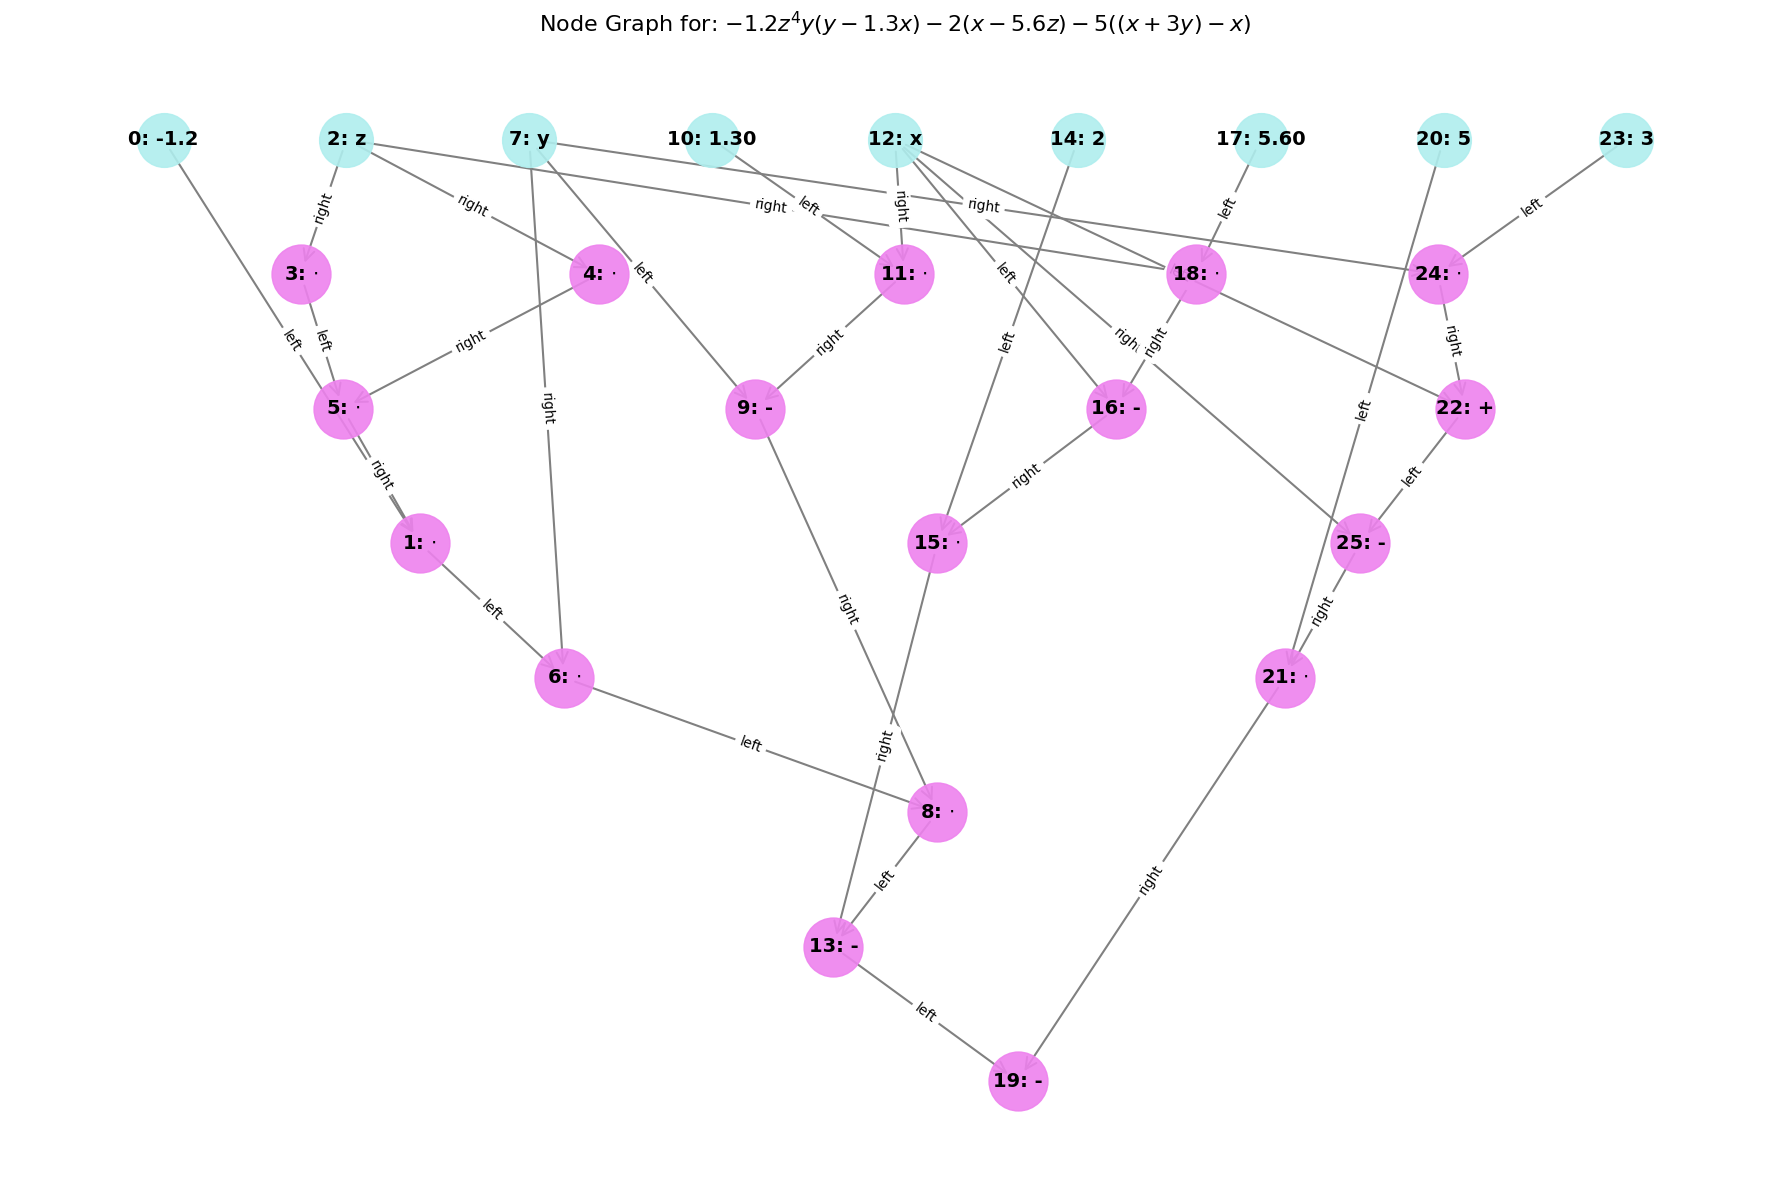

In [7]:
G_mod = merge_negatives(G)
display_graph(G_mod, 0, user_input)

In [431]:
for node in range(0,len(G.nodes())):
    #print(G.nodes[node]['label'])

    if G.nodes[node]['label'] == '$\\cdot$':
        # print(node, G.in_edges(node, data = True))
        edges = G.in_edges(node, data = True)
        parent = [edge for edge in edges]

        #If only one edge is pointing to the node, meaning the input is being multiplied by itself
        if len(parent) == 1:
            print(parent)

        # #Fetches child node
        # children = G.successors(node)
        # child = [n for n in children]
        # print(child)


        # #print(G.nodes[right[0][0]]['label'])
        # # Check right parent node and see if it is a multiplication
        # if (G.nodes[right[0][0]]['label'] == "$\\cdot$"):
        #     print(G.nodes[right[0][0]])




[(2, 3, {'label': 'right'})]
[(2, 4, {'label': 'right'})]


In [403]:
for node in range(0,len(G.nodes())):
    #print(G.nodes[node]['label'])

    if G.nodes[node]['label'] == "^2":
        print(node, G.in_edges(node, data = True))
        edges = G.in_edges(node, data = True)
        parent = [edge for edge in edges][0][0]

        #Fetches child node
        children = G.successors(node)
        child = [n for n in children]
        print(child)


        # #print(G.nodes[right[0][0]]['label'])
        # # Check right parent node and see if it is a multiplication
        # if (G.nodes[right[0][0]]['label'] == "$\\cdot$"):
        #     print(G.nodes[right[0][0]])




In [314]:
for node in range(0,len(G.nodes())):
    #print(G.nodes[node]['label'])

    if G.nodes[node]['label'] == "-":
        #print(node, G.in_edges(node, data = True))
        edges = G.in_edges(node, data = True)
        left = [edge for edge in edges if edge[2].get('label') == 'left']
        right = [edge for edge in edges if edge[2].get('label') == 'right']

        #print(G.nodes[right[0][0]]['label'])
        # Check right parent node and see if it is a multiplication
        if (G.nodes[right[0][0]]['label'] == "$\\cdot$"):
            print(G.nodes[right[0][0]])




{'label': '$\\cdot$', 'type': 'operation'}
{'label': '$\\cdot$', 'type': 'operation'}
{'label': '$\\cdot$', 'type': 'operation'}


In [ ]:
def traverse_up_subtractions(G, node, direction='right'):
    # Get incoming edges with data
    edges = G.in_edges(node, data=True)

    # Select parent edge based on current direction
    target_edge = [edge for edge in edges if edge[2].get('label') == direction]

    if not target_edge:
        return node, direction  # No parent in the given direction

    parent_node = target_edge[0][0]
    parent_label = G.nodes[parent_node].get('label')

    if parent_label == "$\\cdot$":
        # Alternate direction and continue recursively
        if direction == 'right':
            next_dir = 'left'
        else:
            next_dir = 'right'

        return traverse_up_subtractions(G, parent_node, next_dir)
    else:
        print(f"Stopping at node {parent_node} with label {parent_label} on the {direction}")
        return parent_node, direction


for node in G.nodes:
    if G.nodes[node]['label'] == "-":
        print("Node is: ", node)
        stop_node, stop_dir = traverse_up_subtractions(G, node, direction='right')

Node is:  7
Stopping at node 8 with label x on the right
Node is:  9
Stopping at node 10 with label 2 on the left
Node is:  12
Stopping at node 2 with label z on the right
Node is:  13
Stopping at node 14 with label 5 on the left
Node is:  17
Stopping at node 8 with label x on the left
Node is:  19
Stopping at node 2 with label z on the right
